In [ ]:
!git clone https://github.com/asurt-shell-ai/Pitch-The-Future

In [ ]:
%cd Pitch-The-Future

In [ ]:
!pip install -r 'requirements.txt'

In [ ]:
from utils import *
from models import *
from datasets import *
import torch

file_path = './configs/Glow/shapes.yaml'
configs = ConfigParser(file_path)
print("Loaded Configs")

print("Loading Dataset")
img_size, loaded_datasets = load_dataset(configs.dataset, configs.batch_size, configs.n_bits)
configs.img_size = img_size
print("Dataset Loaded")

print("Starting Logger")
logger = Logger(configs)
print("Logger Ready")

print("Creating Model")
model_command = configs.model+"(configs, loaded_datasets, logger)"
model = eval(model_command)

try:
    model.load_state_dict(torch.load(configs.save_model_path))
    print("Loaded a trained model")
except:
    print("No trained model present")

print("Model created successfully")
    

if configs.use_cuda and torch.cuda.is_available():
    print("Using GPU")
    model = model.cuda()

# print("Started Training")
# model.full_train()

In [6]:
from sklearn.metrics import accuracy_score

from PIL import Image
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
plt.style.use('ggplot')


def add_noise_bitflips(test_data, flips_ratio):
    """
    Takes in input images (test_data) and percentage of pixels flipped (flips_ratio)
    and returns the images with half of them corrupted

    Parameters
    ----------
    test_data: np.ndarray (n_images, n_channels, height, width)
    flips_ratio: float [0,1] 

    Returns
    -------
    test_data: np.ndarray (n_images, n_channels, height, width)

    """
    
    n_corrupt = int(0.5*test_data.shape[0])
    flips = (np.random.rand(*test_data[n_corrupt:,].shape) < flips_ratio).astype(int)

    test_data = np.copy(test_data)
    test_data[n_corrupt:,] = np.logical_xor(test_data[n_corrupt:,].astype(int) ,flips).astype(float)
    
    test_labels = np.zeros(test_data.shape[0])
    test_labels[n_corrupt:] = 1

    return test_data, test_labels



def draw_roc_curve(preds, labels, thresholds, title):
    fpr = []
    tpr = []
    for t in thresholds:
        class_preds = preds<t
        tn, fp, fn, tp = confusion_matrix(labels, class_preds).ravel()
        fpr.append(fp/(fp+tn))
        tpr.append(tp/(tp+fn))
    
    # Draw ROC curve
    plt.title(title)
    plt.plot(fpr, tpr)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()
  

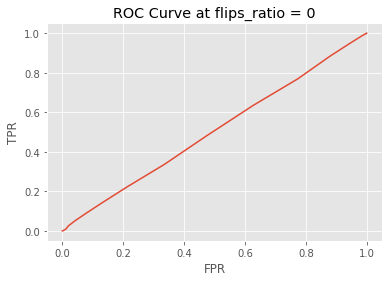

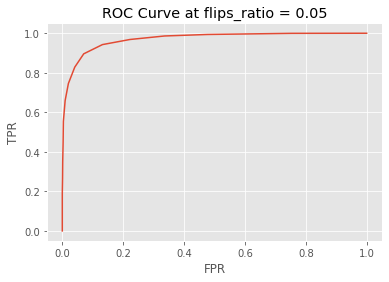

In [7]:
device = next(model.parameters()).device

# Loading nonanomalous images
train_loader, val_loader, test_loader = loaded_datasets

test_data = test_loader.dataset.images
test_data = test_data.detach().cpu().numpy()

# Sanity check, adding almost no noise -> should get a linear ROC curve
test_data_noise, test_labels = add_noise_bitflips(test_data, flips_ratio= 0)
test_data_noise  = torch.from_numpy(np.array(test_data_noise,dtype=float)).type(torch.FloatTensor).to(device)
draw_roc_curve(model.log_prob(test_data_noise).detach().cpu().numpy()
        , test_labels, np.arange(-1e5,0,10), "ROC Curve at flips_ratio = 0")


# ROC curve with ratio = 0.05
flips_ratio = 0.05
test_data_noise, test_labels = add_noise_bitflips(test_data, flips_ratio= flips_ratio)
test_data_noise  = torch.from_numpy(np.array(test_data_noise,dtype=float)).type(torch.FloatTensor).to(device)
draw_roc_curve(model.log_prob(test_data_noise).detach().cpu().numpy()
        , test_labels, np.arange(-1e5,0,10), f"ROC Curve at flips_ratio = {flips_ratio}")

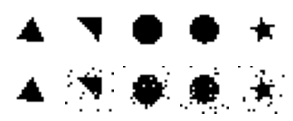

In [8]:
# Plotting non-corrupted images against their corrupted versions with flip ratio 0.05
fig = plt.figure(figsize=(2, 5))
columns = 5
rows = 2 
ax = []
for i in range(0, columns*rows):
    ax.append(fig.add_subplot(rows, columns, i+1))
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])
    ax[-1].grid(False)
    ax[-1].axis('off')
    if(i < (columns*rows / 2)):
        plt.imshow(np.squeeze(test_data[-i]), cmap = "gray")
    else:
        plt.imshow(np.squeeze(test_data_noise[-(i%5)].detach().cpu().numpy()), cmap = "gray")
        
plt.show()